In [1]:
# credit to https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/

import random
import gym
import math
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# alpha, alpha_decay: params of the adam optimizer of the NN (DQN)
# batch size: used for training the DQN (experience replay)
# n_episodes: how long to train for

# gamma: discount factor of future actions based on randomness
# here there's no randomness

# epsilon, min and decay control what % of the time the model tries new things vs uses experience over time
# ideally first the model tries new things then it learns and just uses experience.. 

class DQNCartPoleSolver():
    def __init__(self, n_episodes=1000, n_win_ticks=195, max_env_steps=None, gamma=1.0, epsilon=1.0, 
         epsilon_min=0.01, epsilon_log_decay=0.995, alpha=0.01, alpha_decay=0.01, 
         batch_size=64, monitor=False, quiet=False):
        
        self.memory = deque(maxlen=100000)
        self.env = gym.make('CartPole-v0')
        if monitor: self.env = gym.wrappers.Monitor(self.env, '../data/cartpole-1', force=True)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_log_decay
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.n_episodes = n_episodes
        self.n_win_ticks = n_win_ticks
        self.batch_size = batch_size
        self.quiet = quiet
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps

        # Init model
        self.model = Sequential()
        # the model takes four inputs as the state (cart position, velocity, stick angle, velocity at tip)
        # https://github.com/openai/gym/wiki/CartPole-v0
        self.model.add(Dense(24, input_dim=4, activation='tanh'))
        self.model.add(Dense(48, activation='tanh'))
        # model outputs two numbers - cumulative rewards for two available actions 
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=self.alpha, decay=self.alpha_decay))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    # return a random action if epsilon is high and a model prediction if epsilon is low.. 
    # our model predicts scores of all available actions (two) based on a state...
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.model.predict(state))

    # epsilon gradually declines over time until the min
    def get_epsilon(self, t):
        return max(self.epsilon_min, min(self.epsilon, 1.0 - math.log10((t + 1) * self.epsilon_decay)))

    def preprocess_state(self, state):
        return np.reshape(state, [1, 4])

    def replay(self, batch_size):
        x_batch, y_batch = [], []
        
        # use just the batch size for training
        minibatch = random.sample(
            self.memory, min(len(self.memory), batch_size))
        
        # training follows the recursive Bellman equation..
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model.predict(state)
            # should produce two numbers, scores for two actions.. 
            # action is 1 or 0
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def run(self):
        scores = deque(maxlen=100)

        for e in range(self.n_episodes):
            state = self.preprocess_state(self.env.reset())
            done = False
            i = 0
            
            # play the game until lose
            while not done:
                # action is 0 or 1
                action = self.choose_action(state, self.get_epsilon(e))
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocess_state(next_state)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1

            scores.append(i)
            mean_score = np.mean(scores)
            if mean_score >= self.n_win_ticks and e >= 100:
                if not self.quiet: print('Ran {} episodes. Solved after {} trials ✔'.format(e, e - 100))
                return e - 100
            if e % 100 == 0 and not self.quiet:
                print('[Episode {}] - Mean survival time over last 100 episodes was {} ticks.'.format(e, mean_score))

            # training happens here.
            self.replay(self.batch_size)
        
        if not self.quiet: print('Did not solve after {} episodes 😞'.format(e))
        return e

In [4]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [5]:
agent = DQNCartPoleSolver(n_episodes=1000, n_win_ticks=195)

I0709 02:39:15.733866 140584374011648 registration.py:117] Making new env: CartPole-v0
/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
W0709 02:39:15.741782 140584374011648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 02:39:15.758600 140584374011648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 02:39:15.761010 140584374011648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.unifo

In [6]:
# train
agent.run()

W0709 02:39:19.618480 140584374011648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0709 02:39:19.620487 140584374011648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[Episode 0] - Mean survival time over last 100 episodes was 14.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 15.19 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 16.72 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 19.4 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 18.99 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 28.04 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 30.41 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 34.38 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 39.65 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 46.47 ticks.
Did not solve after 999 episodes 😞


999

In [7]:
env = gym.make('CartPole-v0')
observation = env.reset()


I0709 02:40:11.234894 140584374011648 registration.py:117] Making new env: CartPole-v0


In [8]:
cum_reward = 0
frames = []
for t in range(100):
    # Render into buffer. 
    # You will still see the window.
    frames.append(env.render(mode = 'rgb_array'))
#    action = env.action_space.sample()
    # no epsilon, just follow the best strategy
    action = agent.choose_action(agent.preprocess_state(observation), 0)
    observation, reward, done, info = env.step(action)
    print (action, observation, reward, done, info)
#    if done:
#        print("Episode finished after {} timesteps".format(t+1))
#        break
env.render(close=True)

W0709 02:40:13.490957 140584374011648 cartpole.py:85] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


1 [-0.02793797  0.21522376  0.0449085  -0.27553947] 1.0 False {}
1 [-0.02363349  0.40967717  0.03939771 -0.55372685] 1.0 False {}
1 [-0.01543995  0.60422438  0.02832318 -0.83374129] 1.0 False {}
1 [-0.00335546  0.79894813  0.01164835 -1.11738387] 1.0 False {}
0 [ 0.0126235   0.60367527 -0.01069933 -0.8210699 ] 1.0 False {}
1 [ 0.02469701  0.79894198 -0.02712072 -1.11709875] 1.0 False {}
0 [ 0.04067585  0.60418626 -0.0494627  -0.8330451 ] 1.0 False {}
0 [ 0.05275957  0.40977382 -0.0661236  -0.55631921] 1.0 False {}
0 [ 0.06095505  0.21563948 -0.07724999 -0.28518026] 1.0 False {}
1 [ 0.06526784  0.41177331 -0.08295359 -0.60119253] 1.0 False {}
0 [ 0.07350331  0.21790376 -0.09497744 -0.33574858] 1.0 False {}
0 [ 0.07786138  0.02425275 -0.10169241 -0.07446264] 1.0 False {}
1 [ 0.07834644  0.22067442 -0.10318167 -0.39741907] 1.0 False {}
0 [ 0.08275992  0.02715611 -0.11113005 -0.13896706] 1.0 False {}
0 [ 0.08330305 -0.16621323 -0.11390939  0.1166927 ] 1.0 False {}
1 [ 0.07997878  0.0303409


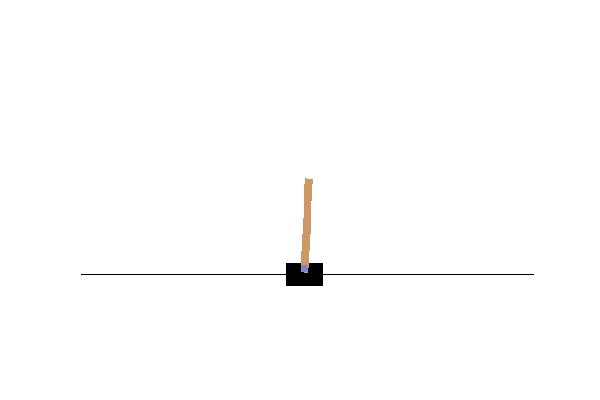
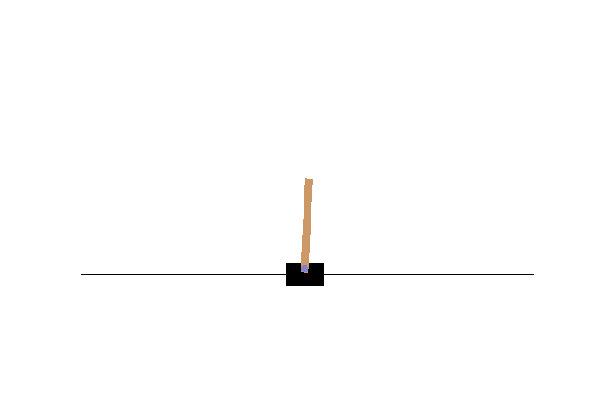
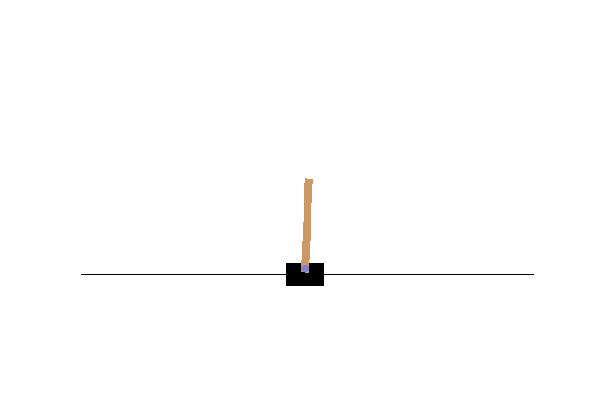
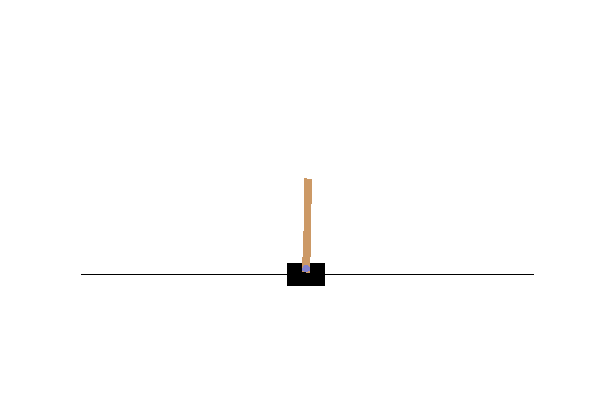
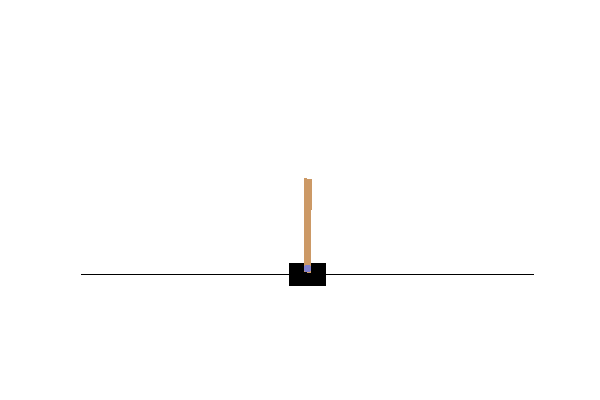
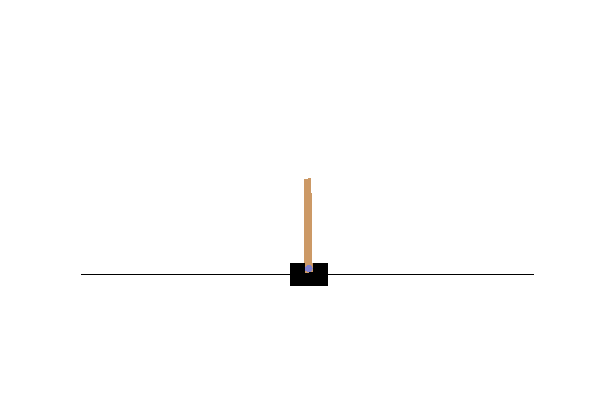
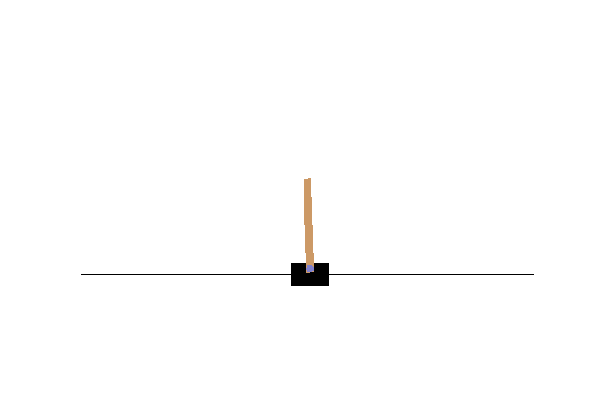
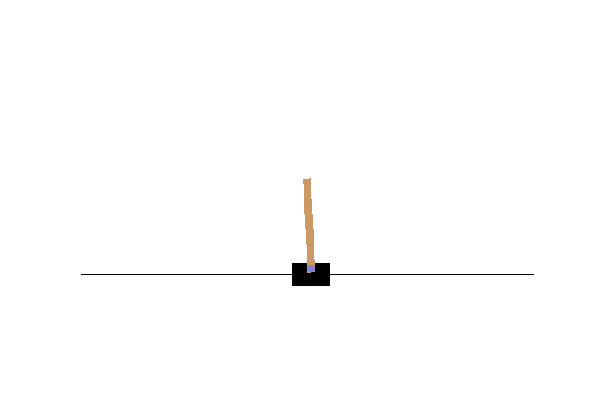
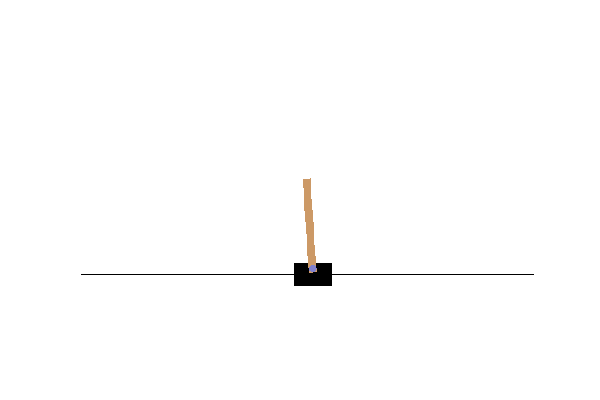
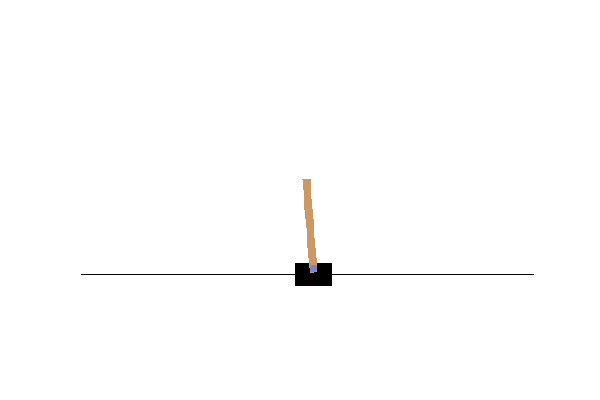
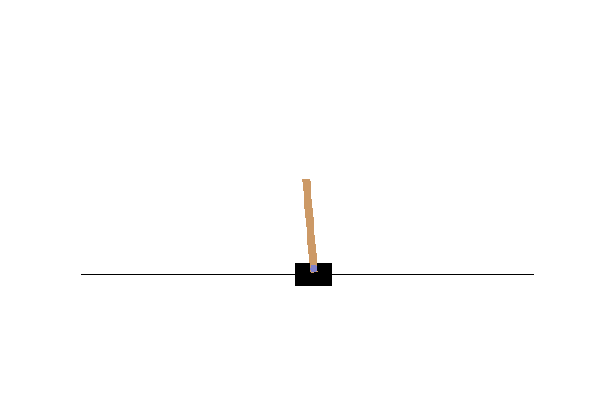
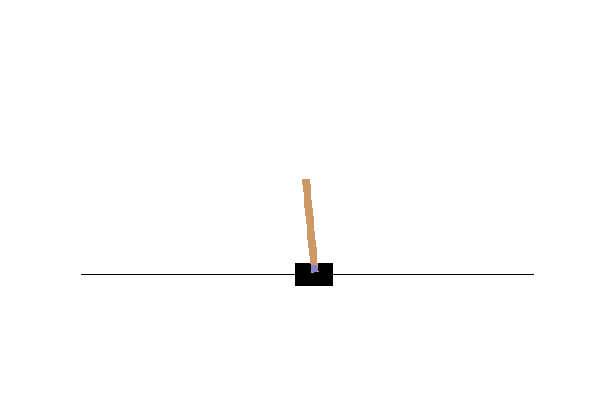
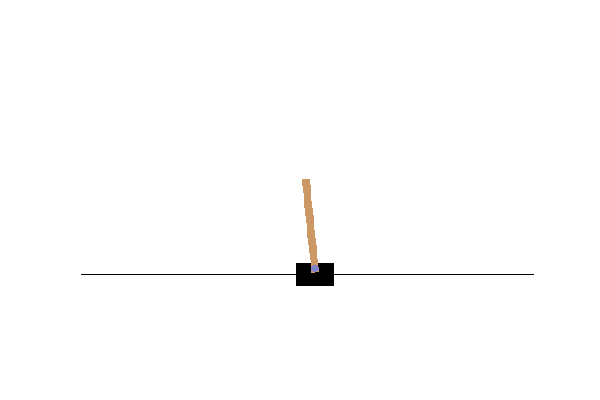
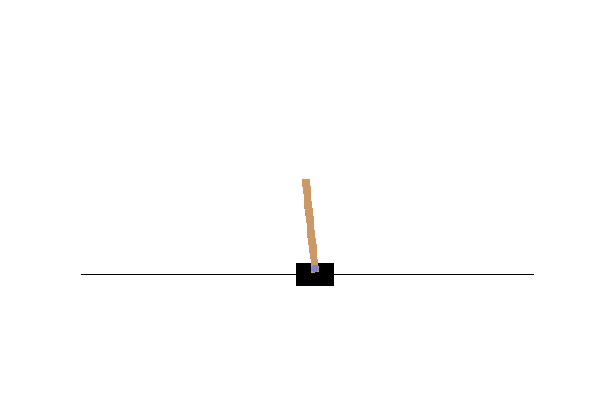
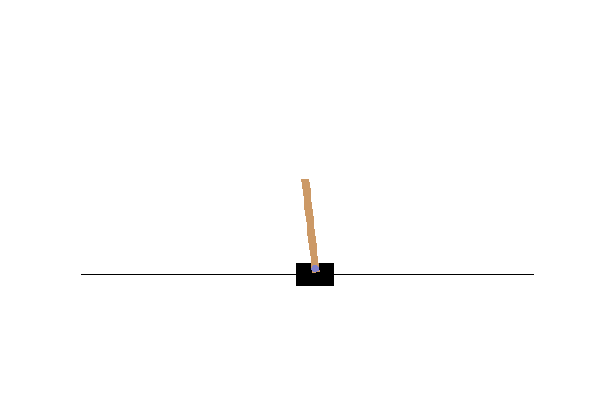
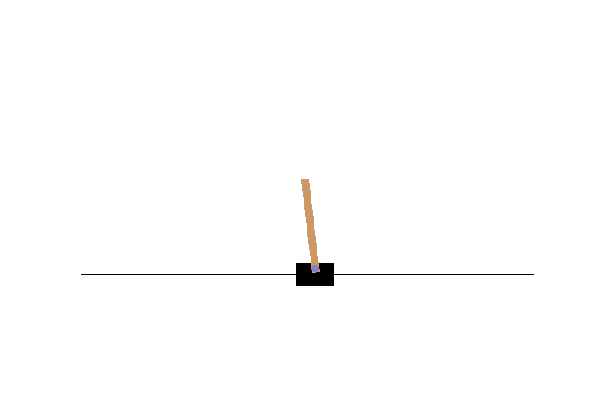
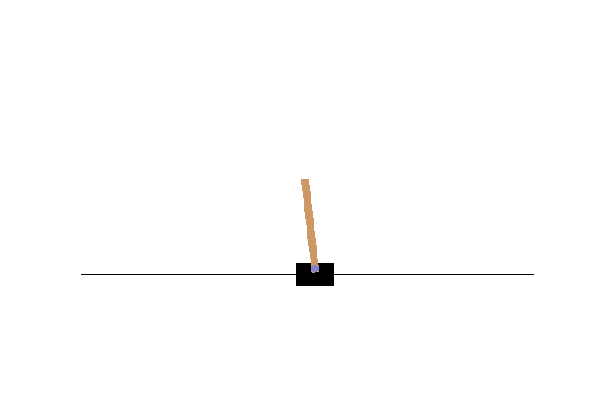
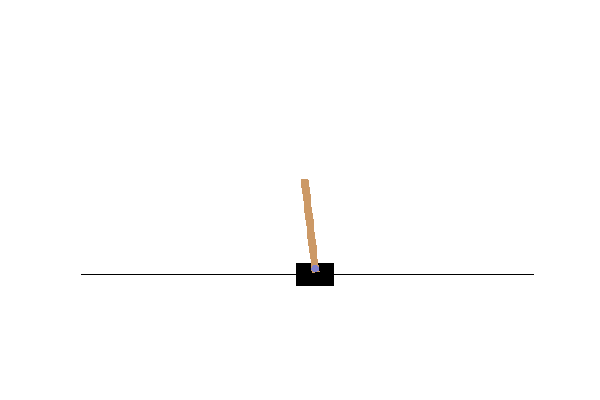
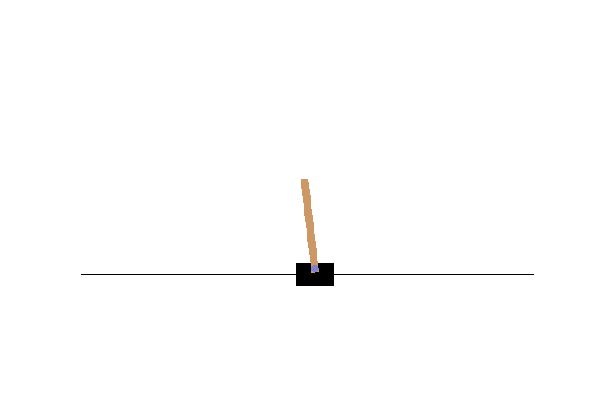
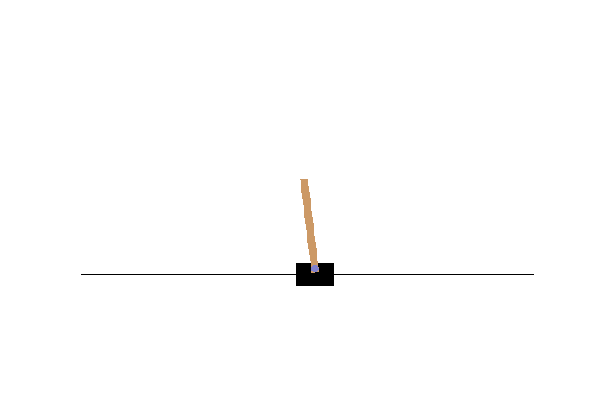
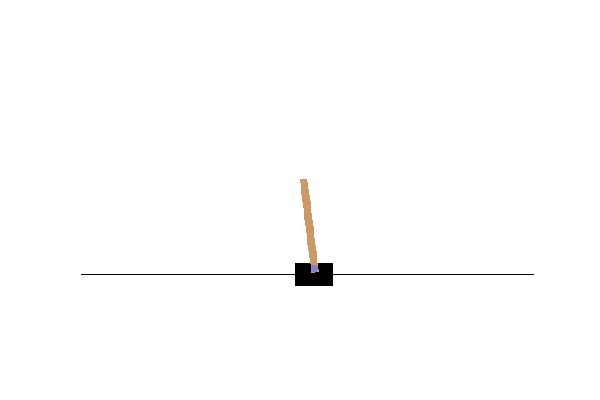
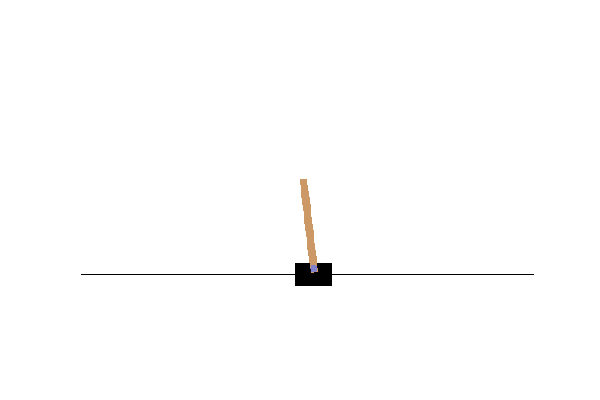
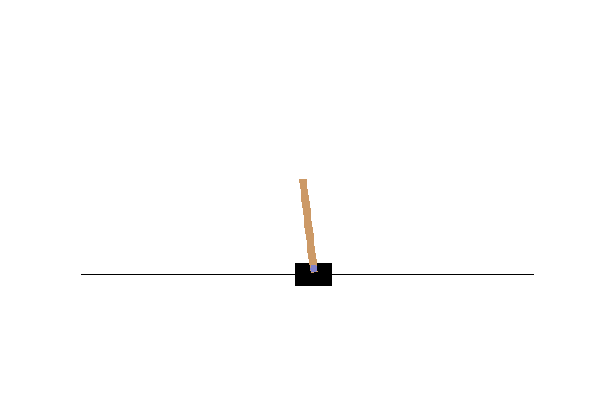
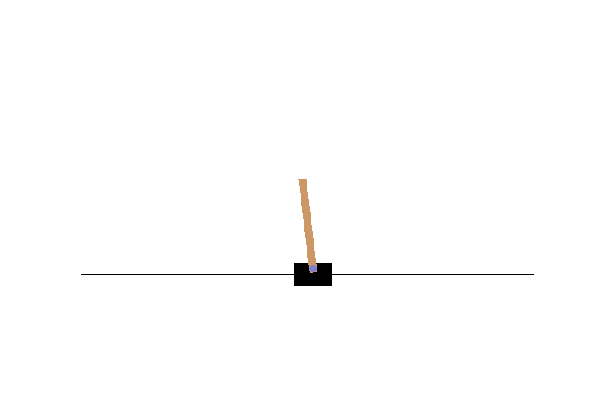
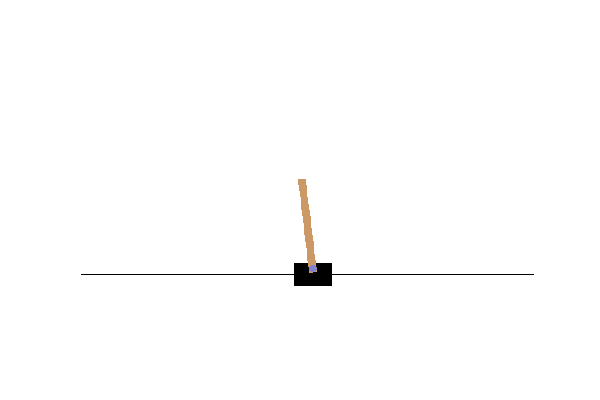
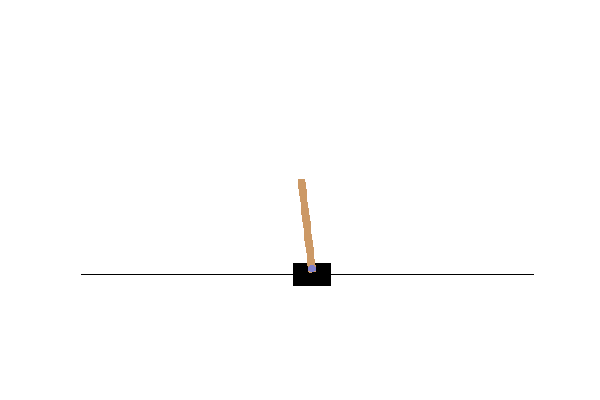
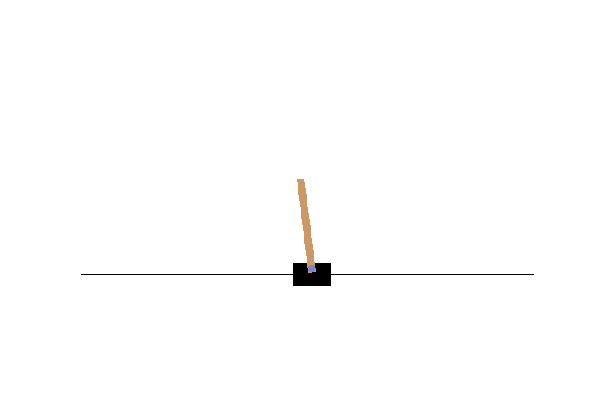
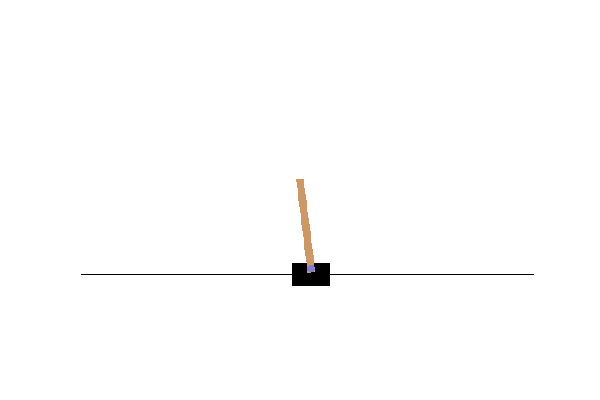
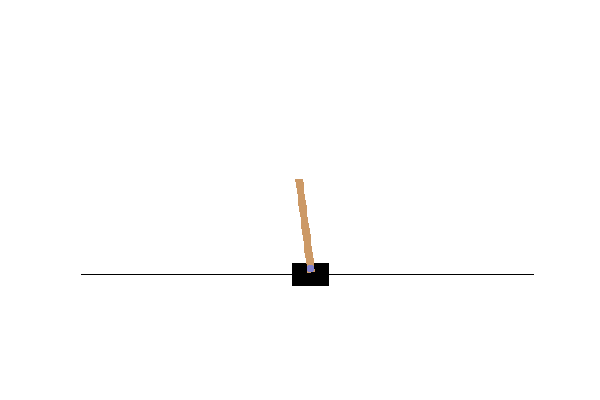
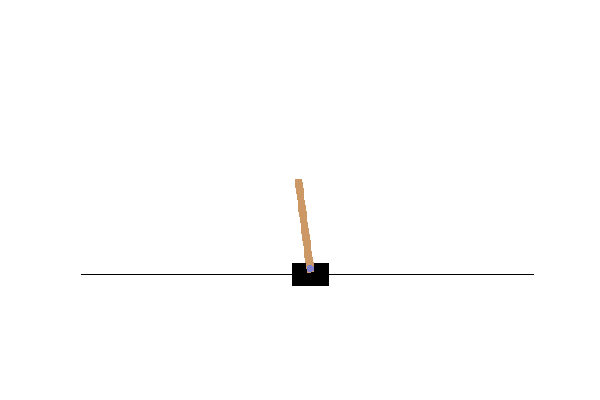
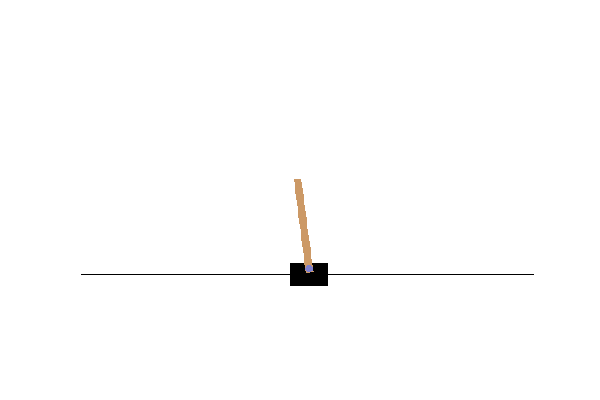
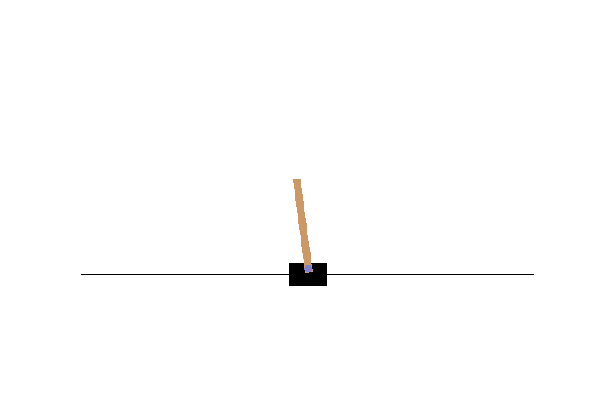
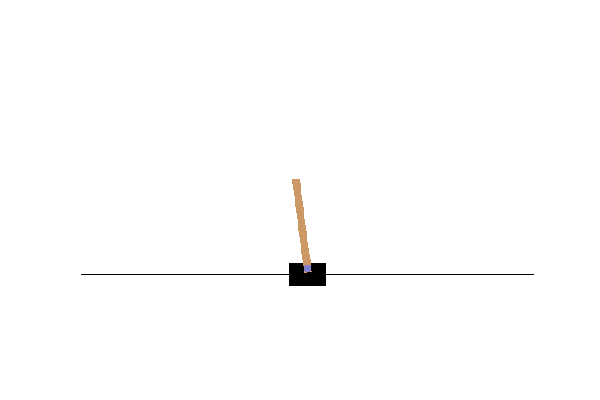
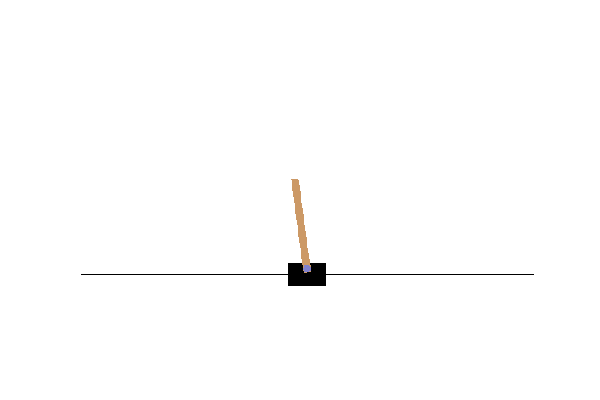
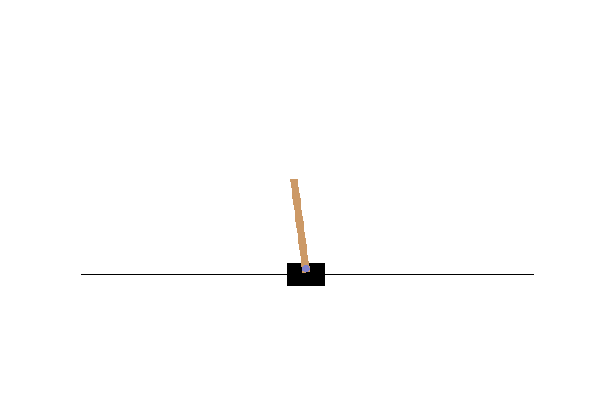
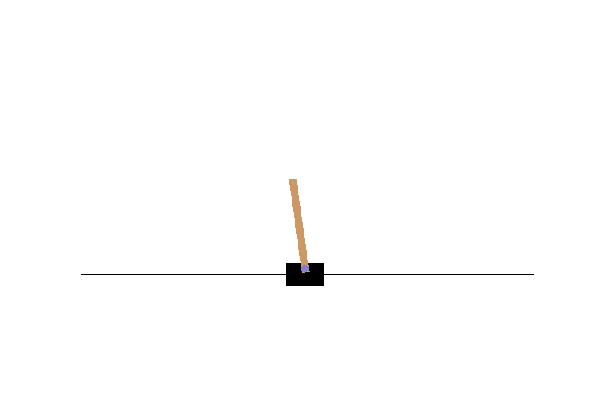
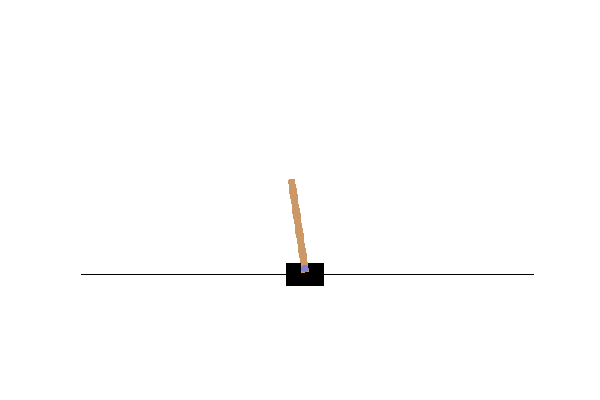
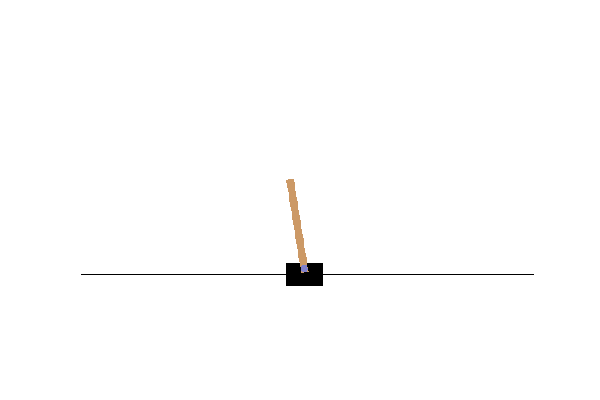
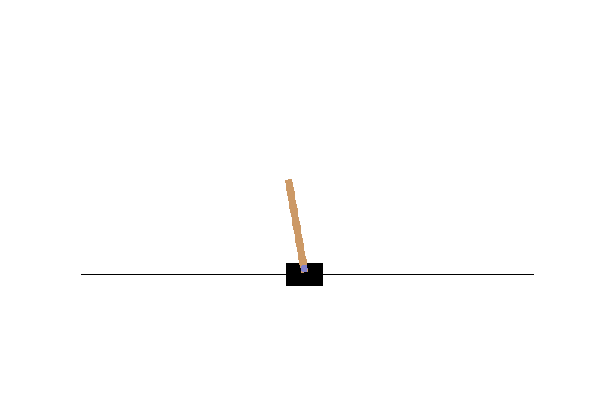
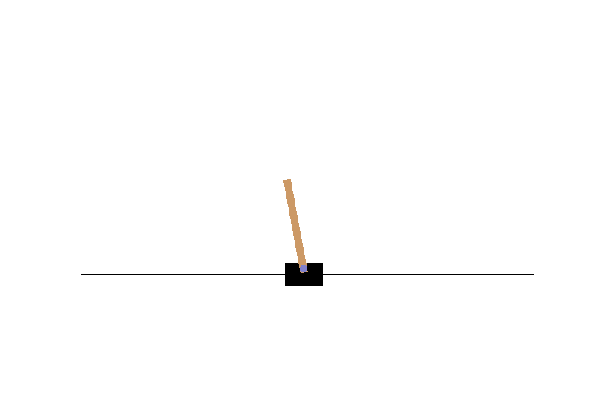
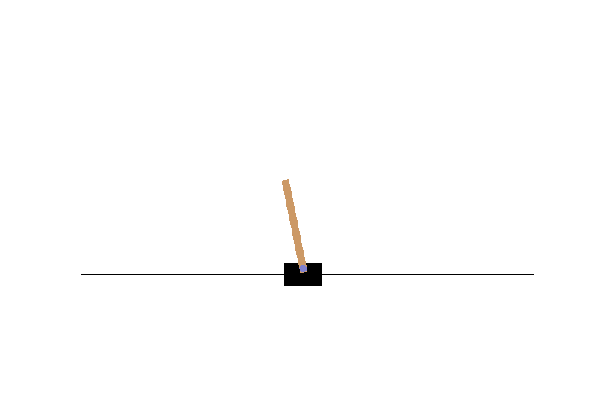
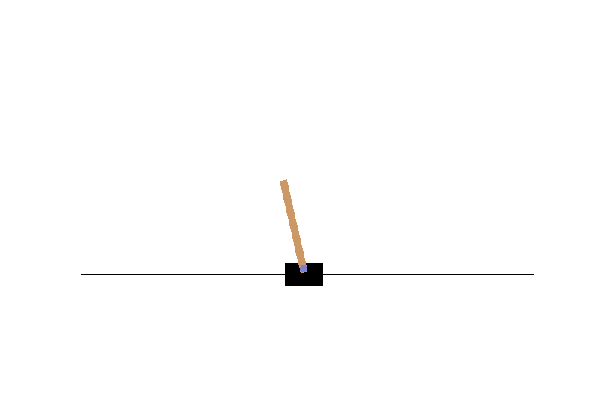
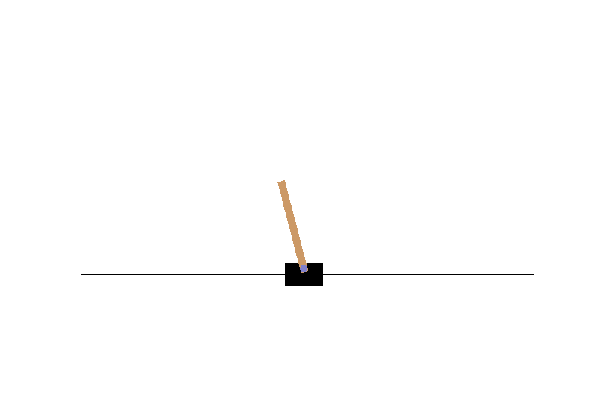
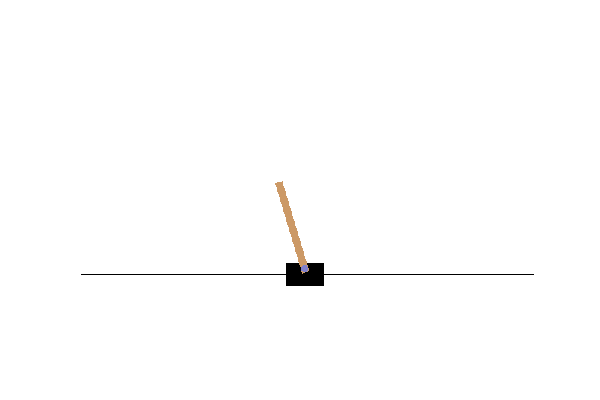
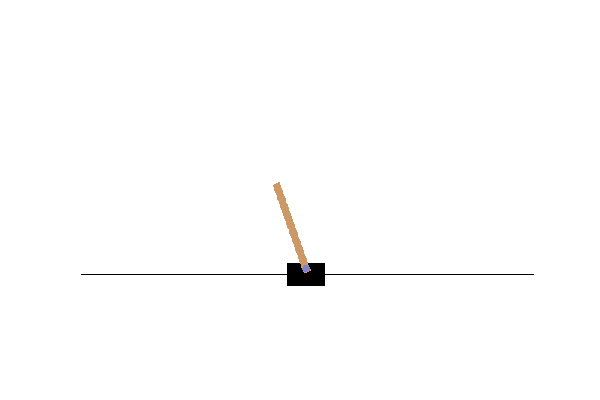
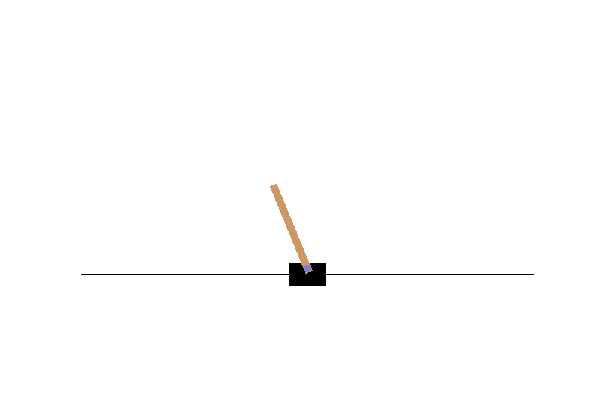
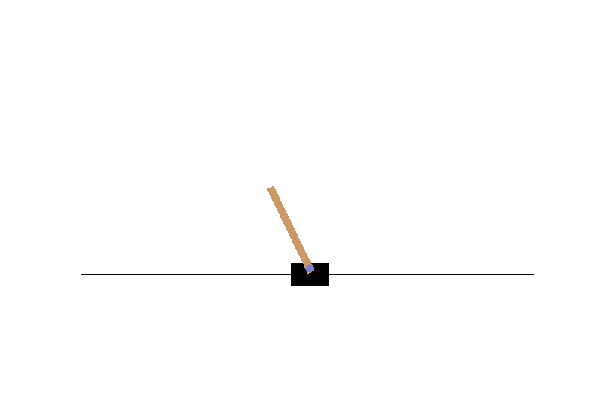
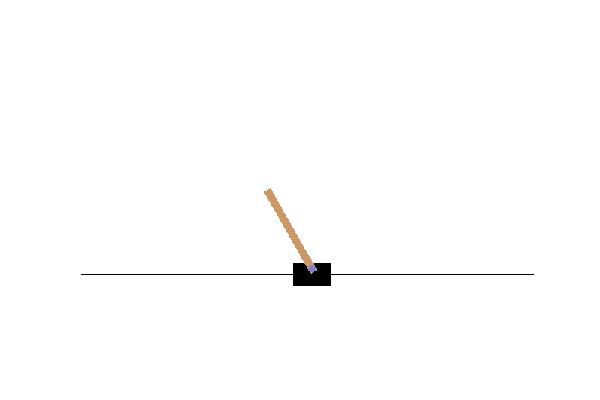
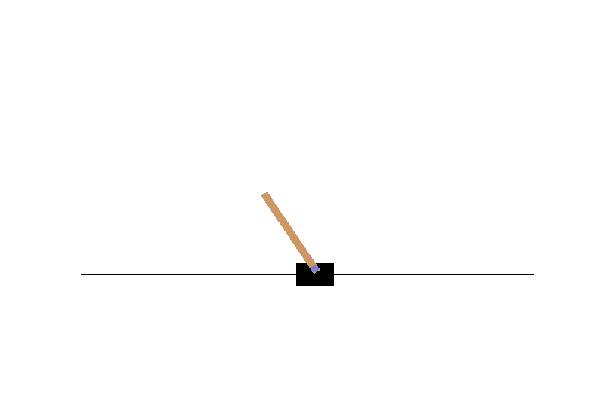
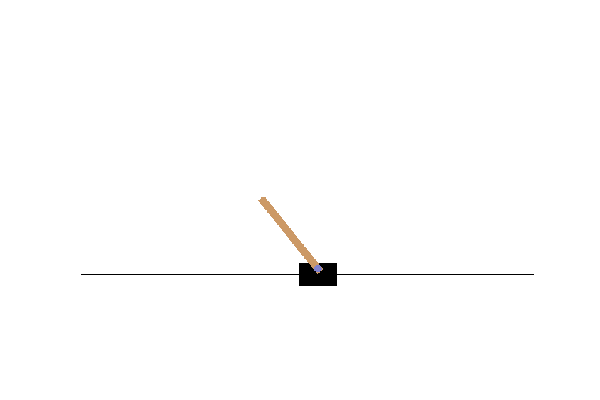
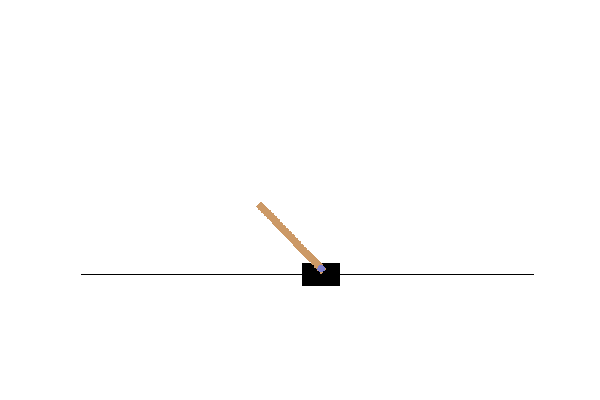
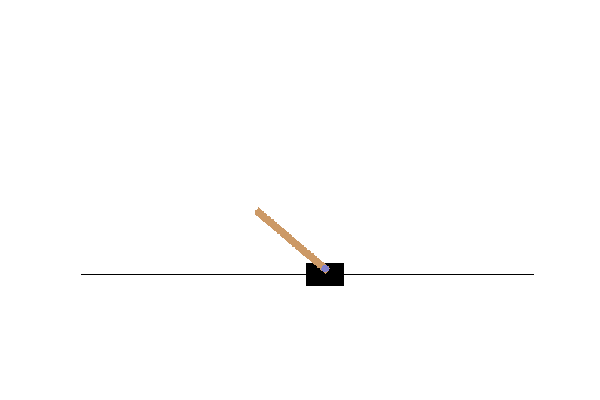
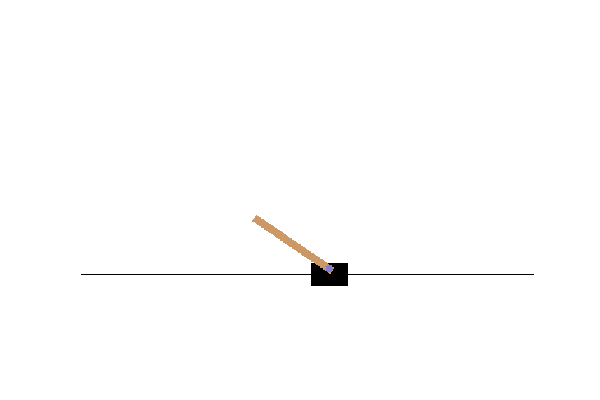
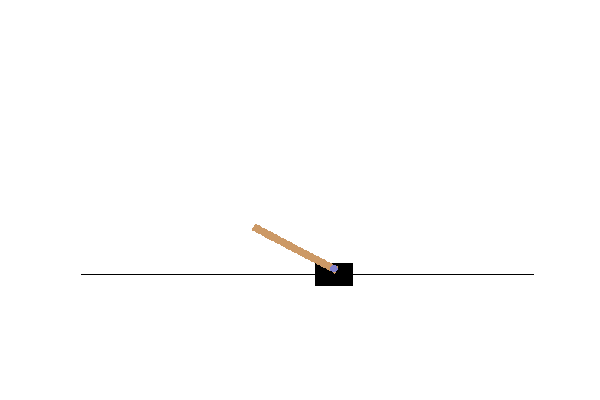
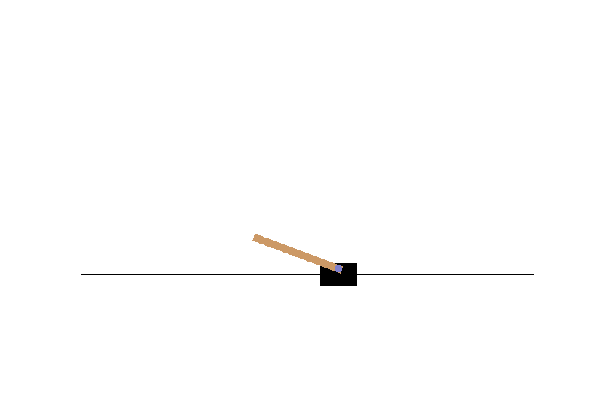
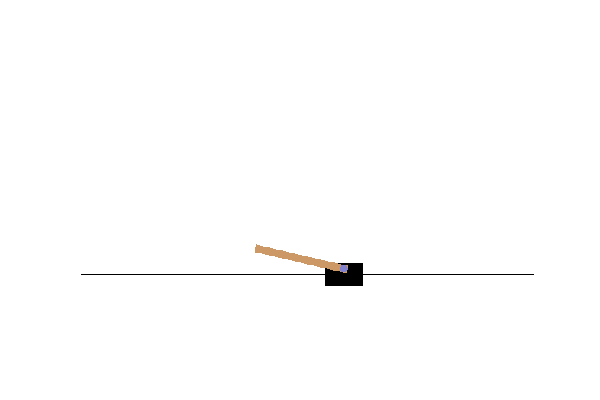
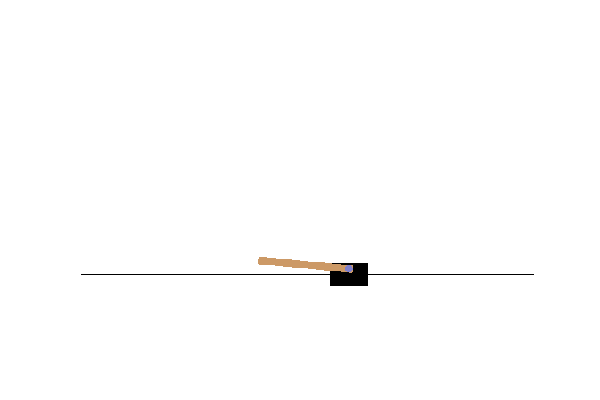
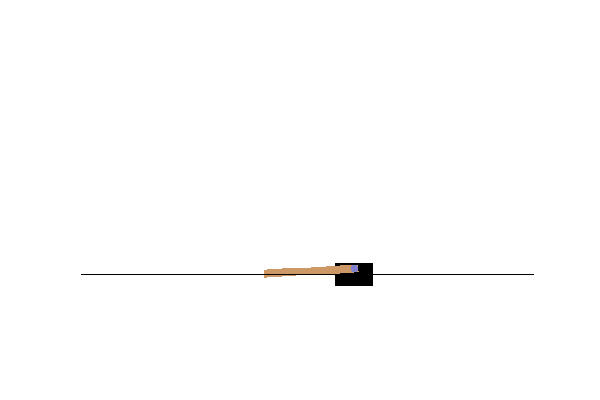
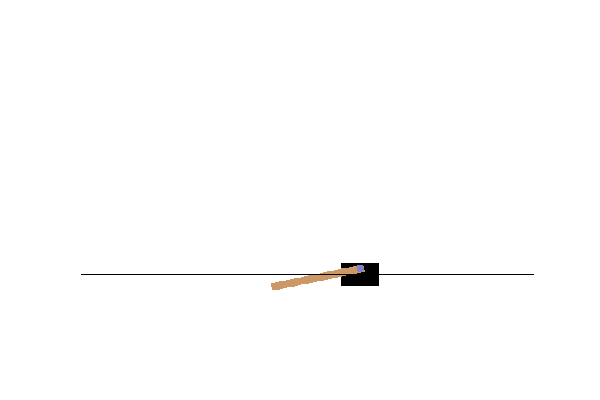
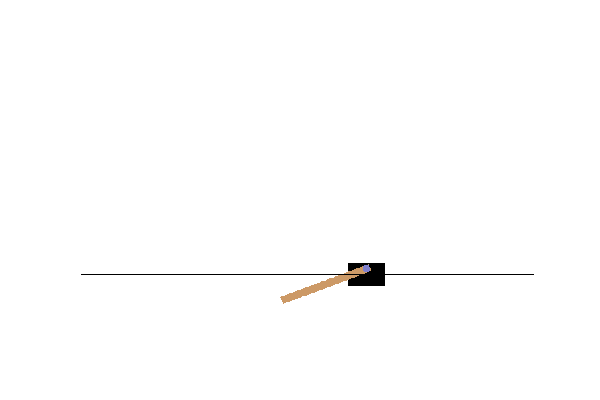
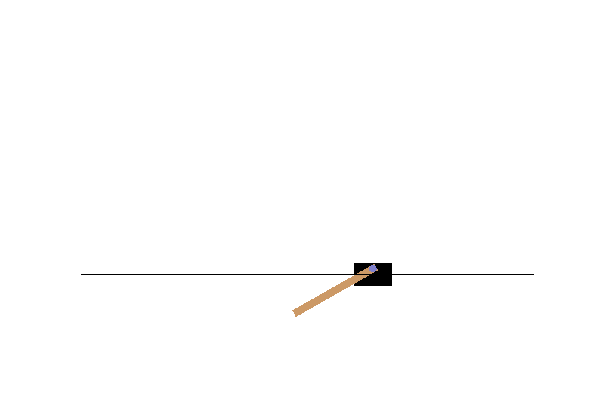
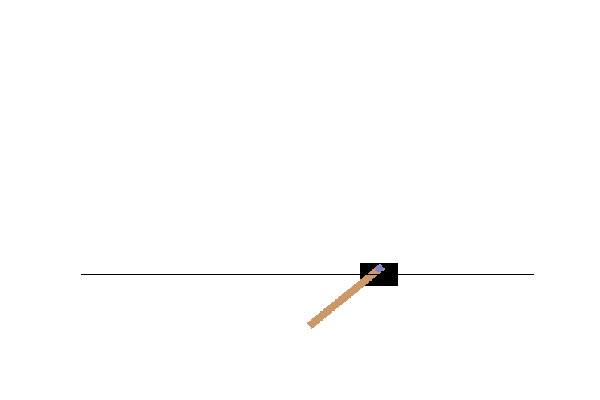
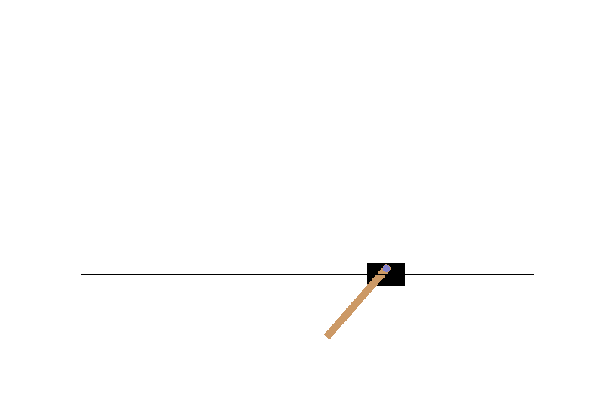
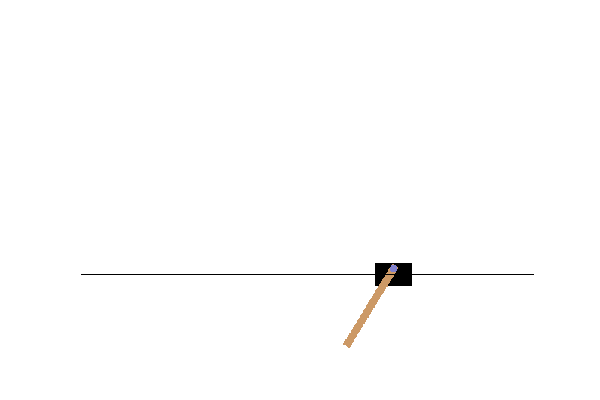
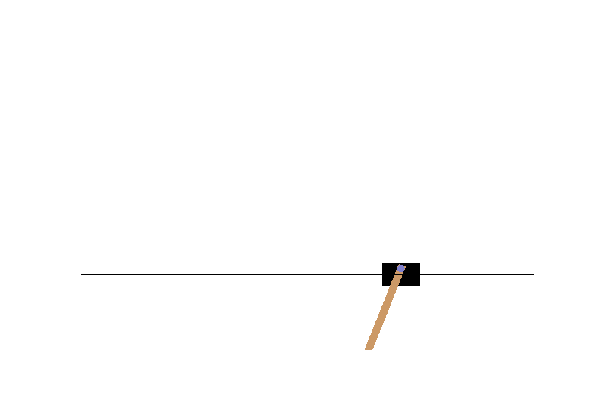
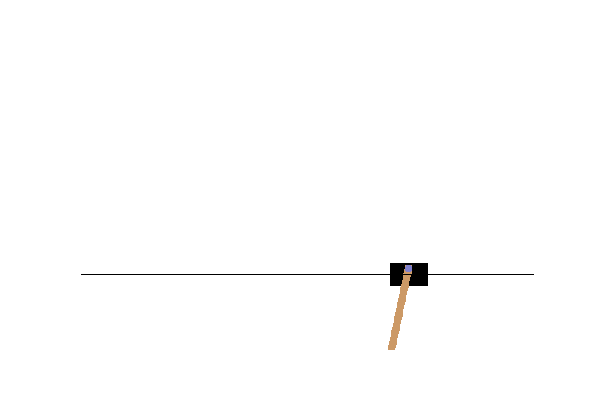
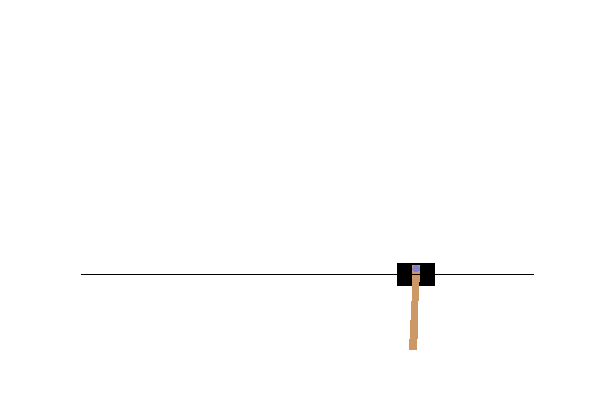
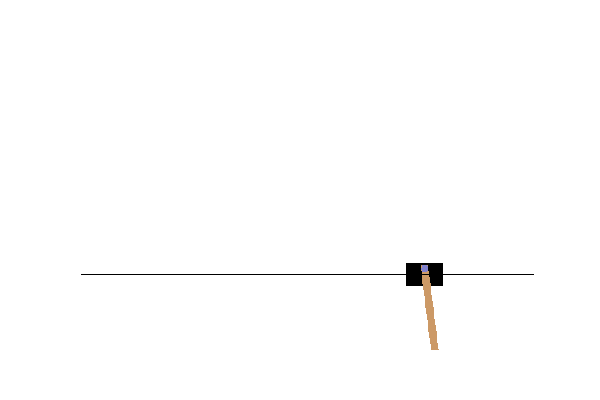
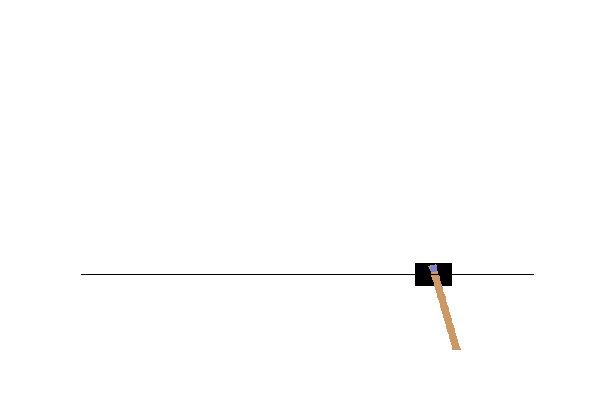
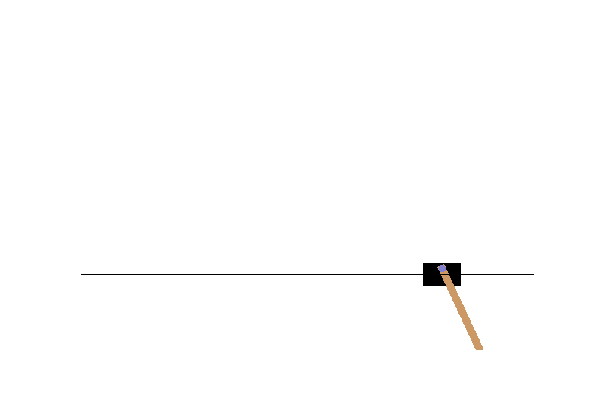
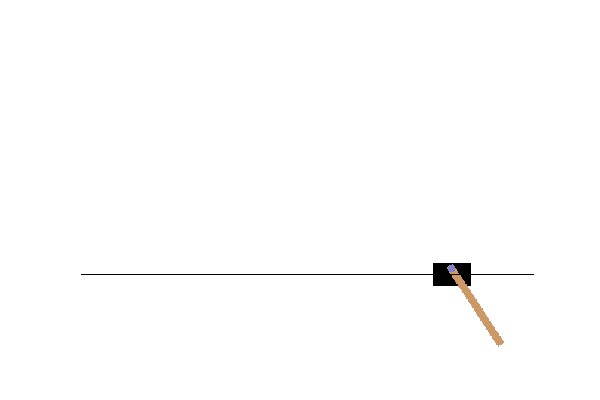
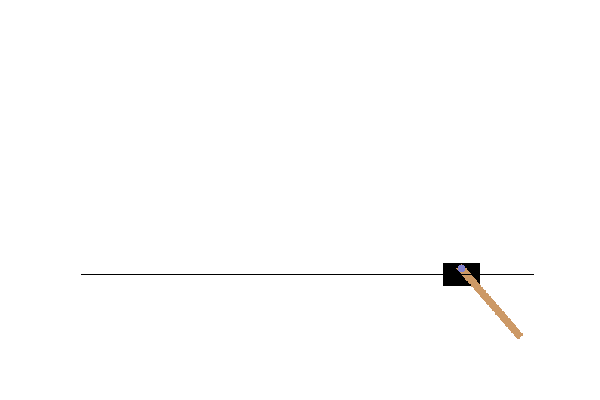
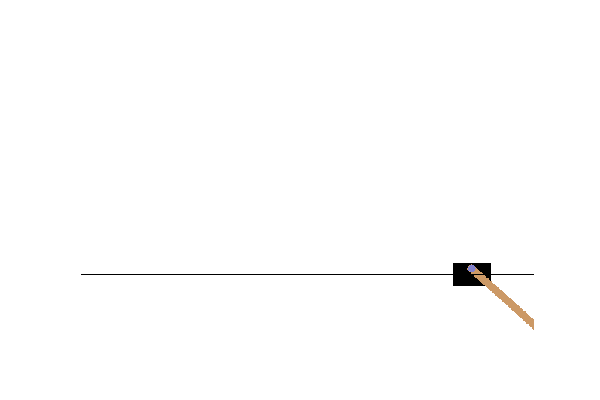
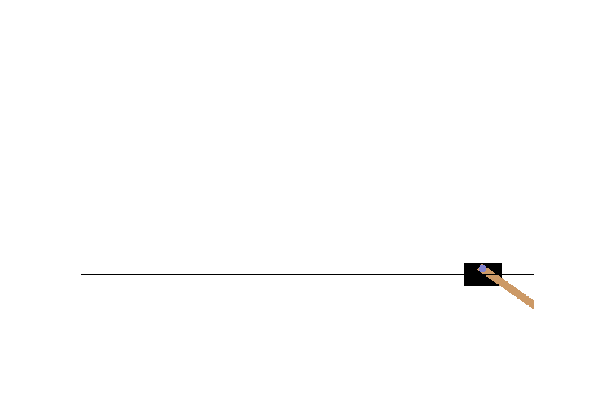
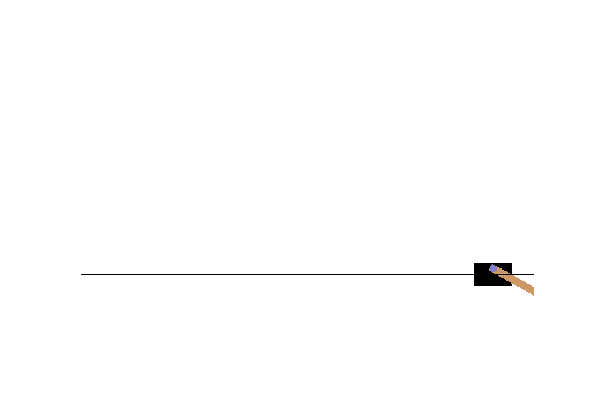
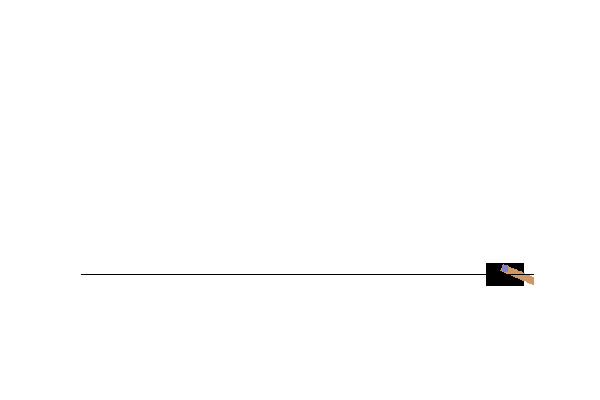
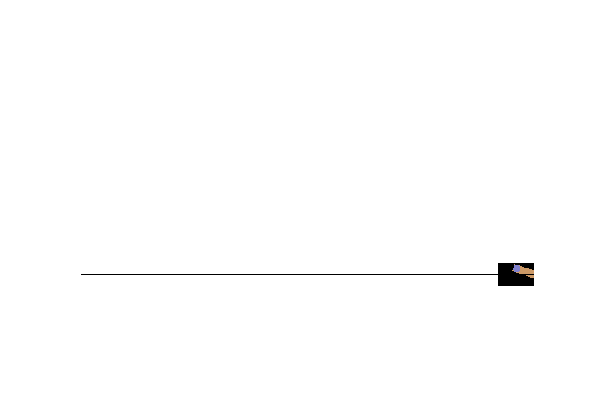
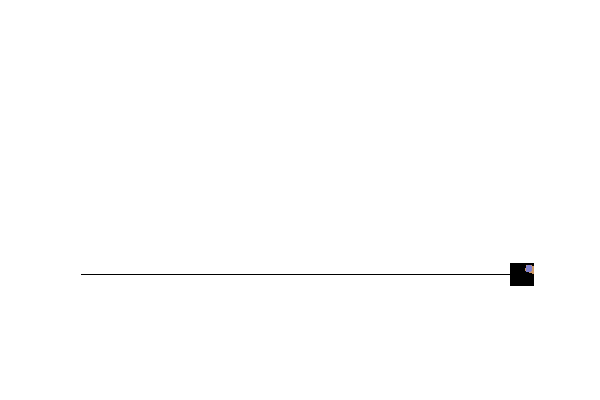
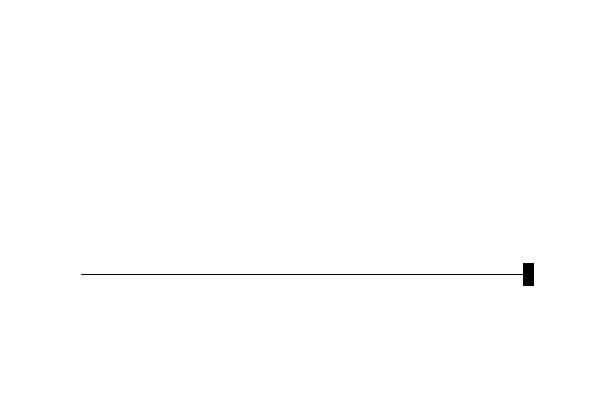
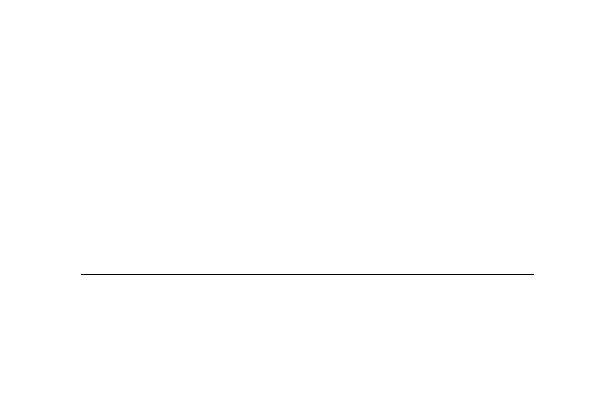
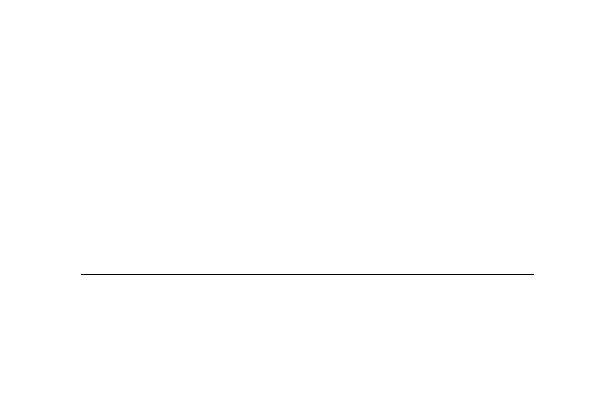
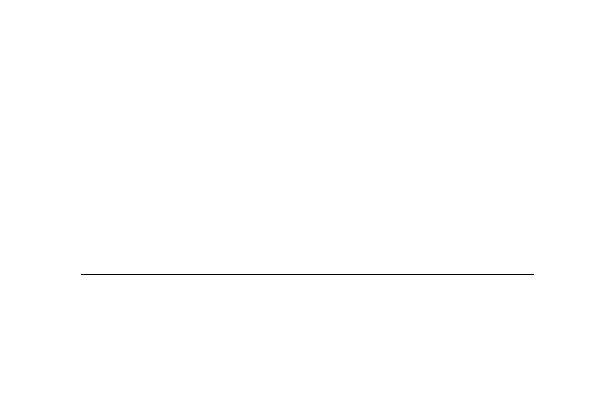
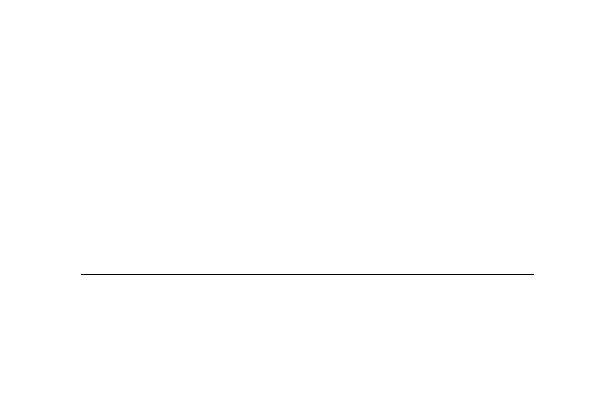
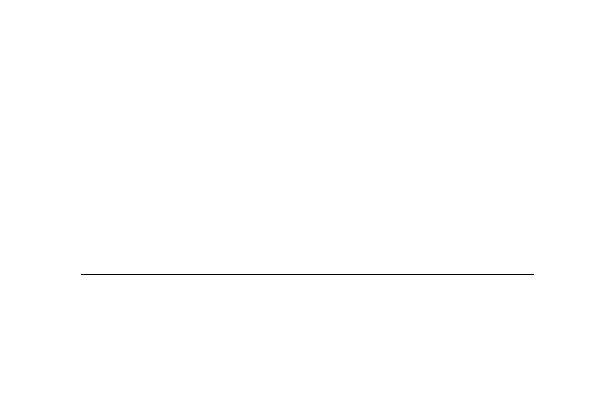
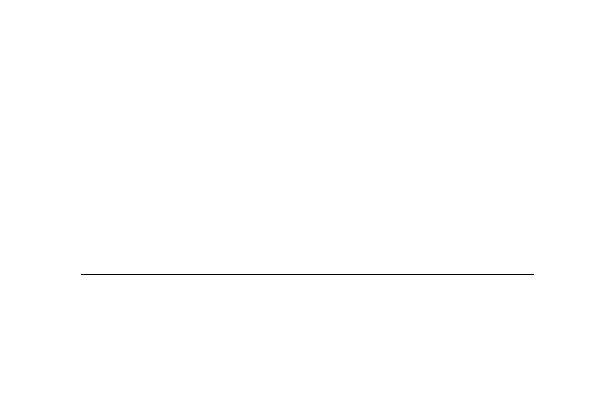
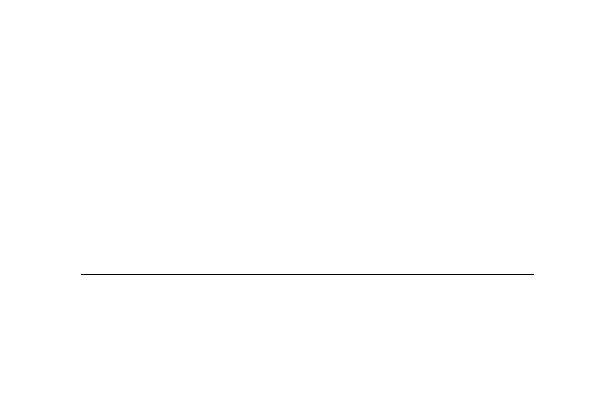
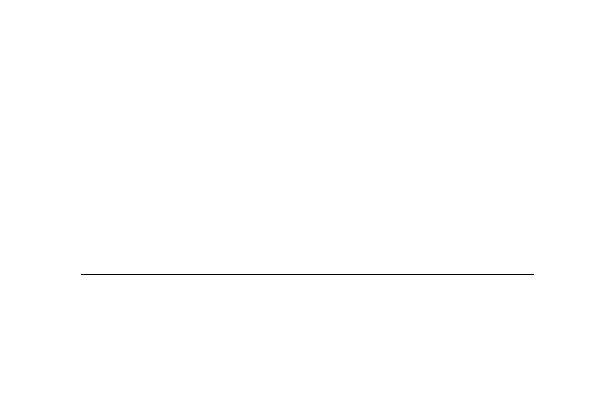
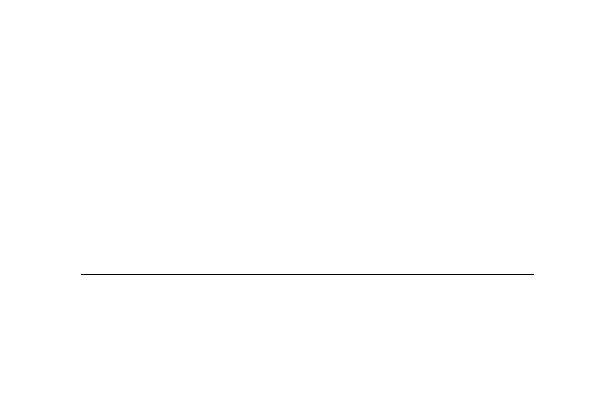
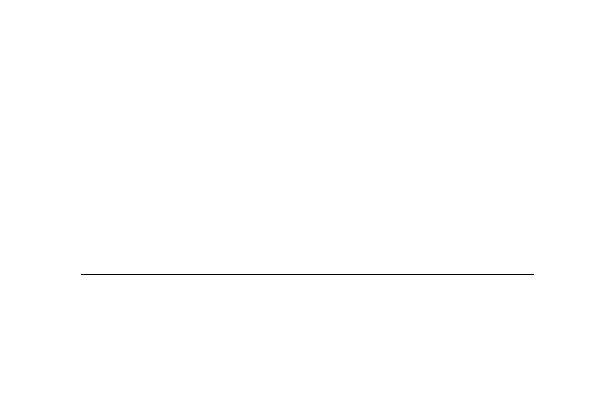
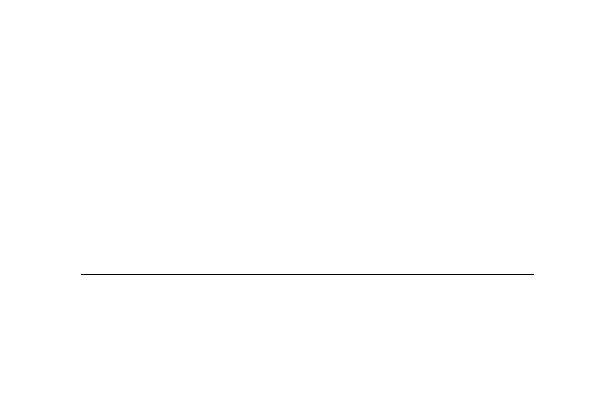
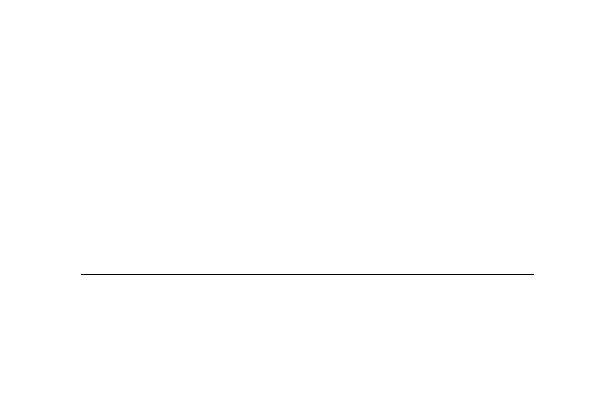
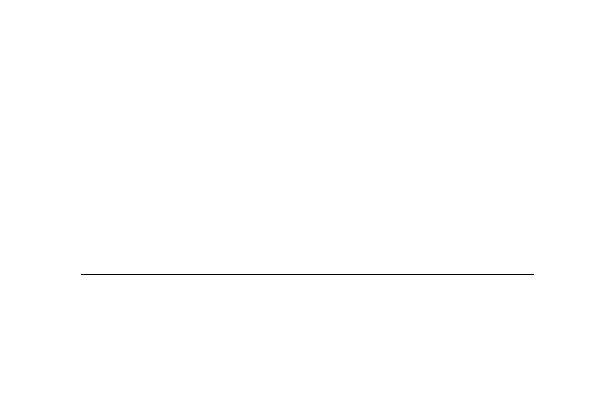
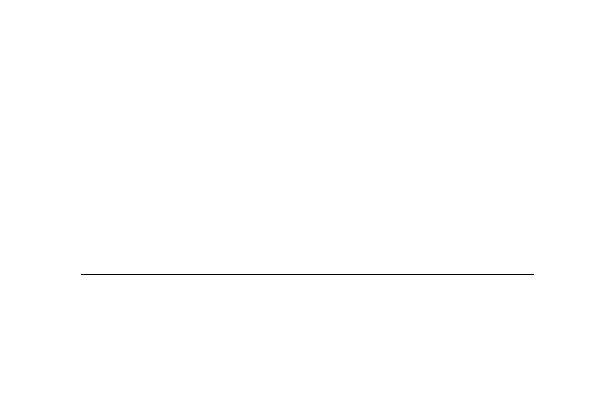
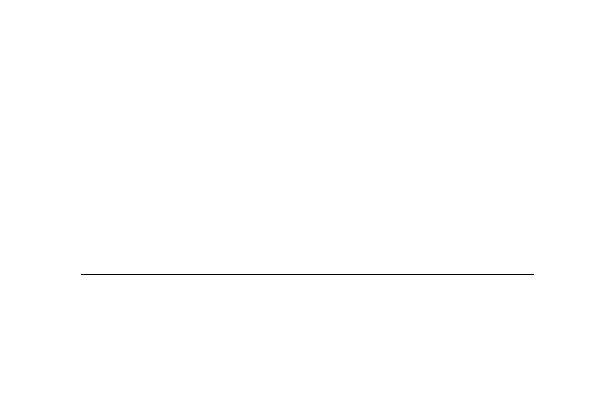
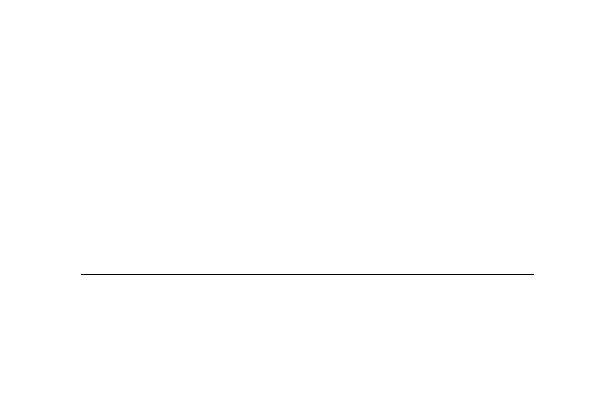
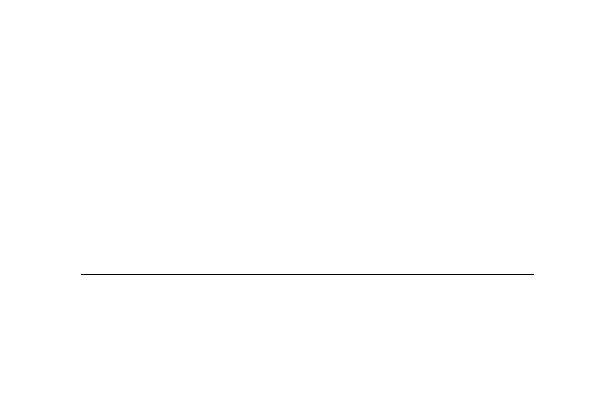
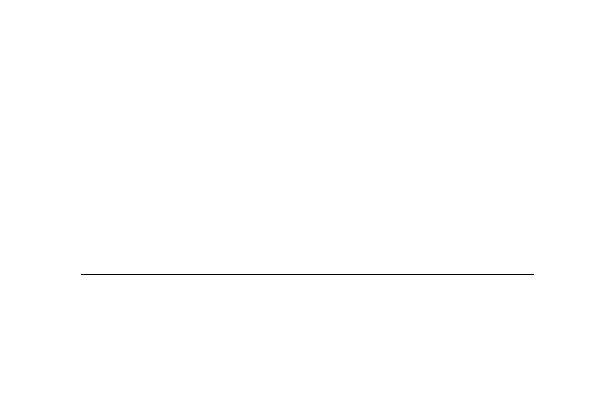
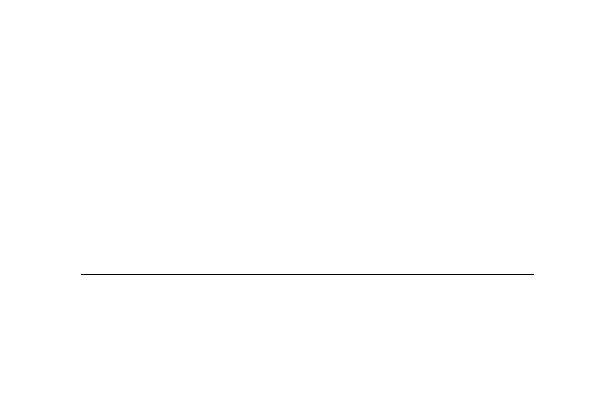
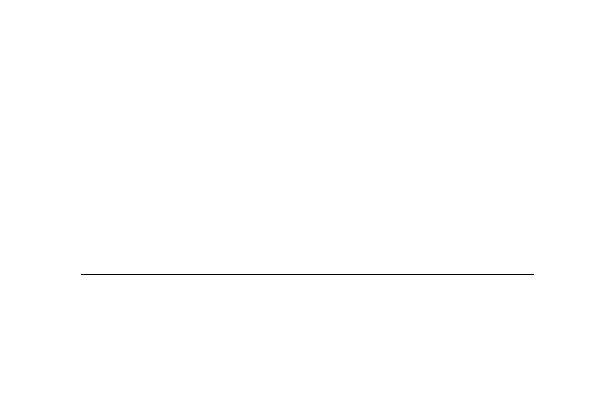
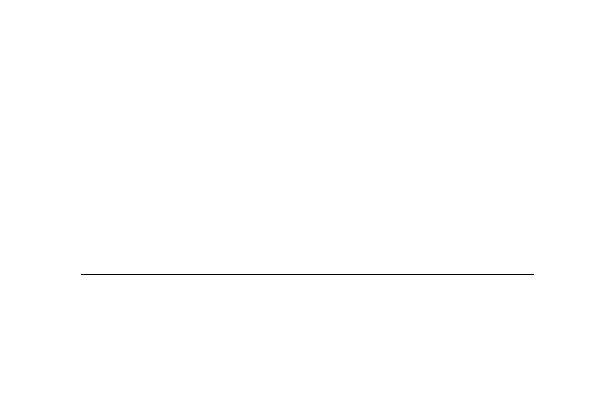

In [9]:
display_frames_as_gif(frames)